# **CNN & RNN IMPLEMENTATION USING KERAS FOR IMAGE CAPTIONING SYSTEM**
(Refer PDf document attached for comparison of CNN & RNN)

### DOWNLOAD THE DATASET & UNZIP IT 

In [1]:
! pip install kaggle          

In [2]:
! mkdir ~/.kaggle 

In [3]:
! cp /content/kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json 

In [5]:
! kaggle datasets download -d kunalgupta2616/flickr-8k-images-with-captions   

 99% 1.03G/1.04G [00:09<00:00, 121MB/s]
100% 1.04G/1.04G [00:09<00:00, 116MB/s]


In [6]:
! unzip /content/archive.zip -d image_captions  # unzipped content folder is --> image_captions 

Streaming output truncated to the last 5000 lines.
  inflating: image_captions/Images/2844846111_8c1cbfc75d.jpg  
  inflating: image_captions/Images/2844963839_ff09cdb81f.jpg  
  inflating: image_captions/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: image_captions/Images/2845691057_d4ab89d889.jpg  
  inflating: image_captions/Images/2845845721_d0bc113ff7.jpg  
  inflating: image_captions/Images/2846037553_1a1de50709.jpg  
  inflating: image_captions/Images/2846785268_904c5fcf9f.jpg  
  inflating: image_captions/Images/2846843520_b0e6211478.jpg  
  inflating: image_captions/Images/2847514745_9a35493023.jpg  
  inflating: image_captions/Images/2847615962_c330bded6e.jpg  
  inflating: image_captions/Images/2847859796_4d9cb0d31f.jpg  
  inflating: image_captions/Images/2848266893_9693c66275.jpg  
  inflating: image_captions/Images/2848571082_26454cb981.jpg  
  inflating: image_captions/Images/2848895544_6d06210e9d.jpg  
  inflating: image_captions/Images/2848977044_446a31d86e.jpg  
  in

### REQUIRED LIBRARIES

In [7]:
# image specific libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os                 
from glob import glob 

In [8]:
from google.colab import drive  # connecting to gdrive for accessing required data in future
drive.mount('/content/drive')   

Mounted at /content/drive


### CREATE TRAIN - TEST IMAGE CAPTIONS 

In [9]:
train_img_cap_dict = {}
train_final_caption_lists = []
train_list_of_desc = []
train_images = []

test_img_cap_dict = {}
test_final_caption_lists = []
test_list_of_desc = []
test_images = []

import random 
random.seed(6)

# totally 8091 x 5 = 40455 captions
captions = list(open('/content/image_captions/captions.txt','r'))[1:]

#NOTE :- > DONOT DO THIS --> random.shuffle(captions)  

# (75 : 25) ratio
# 6000 images --> training & 2091 images --> testing
# Lets consider 6000 x 5 = 30000 captions for training data
for ix,sent in enumerate(captions[0:30000]):
    
    x = ' '.join(sent.split(',')[1:])
    
    train_list_of_desc.append(x)
   
    if (ix+1) % 5 == 0:
      
      fname = sent.split(',')[0]

      train_final_caption_lists.append(train_list_of_desc)

      images_path = '/content/image_captions/Images/'

      train_images.append(images_path+fname)   

      train_list_of_desc = []

# Lets consider remaning captions for test data
for ix,sent in enumerate(captions[30000:]):
    
    x = ' '.join(sent.split(',')[1:])
    
    test_list_of_desc.append(x)
   
    if (ix+1) % 5 == 0:
      
      fname = sent.split(',')[0] 

      test_final_caption_lists.append(test_list_of_desc)

      images_path = '/content/image_captions/Images/'

      test_images.append(images_path+fname)

      test_list_of_desc = []


# train images & captions   
print("Total train images processed -->",len(train_images))    
for idx,img_filename in enumerate(train_images):
    train_img_cap_dict[img_filename] = train_final_caption_lists[idx] 

print("Total train Caption lists -->",len(train_final_caption_lists)) 
print("Total train image-key value pairs -->",len(train_img_cap_dict)) 

print("\n") 
# test images & captions   
print("Total test images processed -->",len(test_images))    
for idx,img_filename in enumerate(test_images):
    test_img_cap_dict[img_filename] = test_final_caption_lists[idx] 

print("Total test Caption lists -->",len(test_final_caption_lists)) 
print("Total test image-key value pairs -->",len(test_img_cap_dict)) 


Total train images processed --> 6000
Total train Caption lists --> 6000
Total train image-key value pairs --> 6000


Total test images processed --> 2091
Total test Caption lists --> 2091
Total test image-key value pairs --> 2091


### DISPLAY THE IMAGE CAPTIONS DICTIONARY

In [10]:
# image caption dictionary
list(train_img_cap_dict.items())[0:2] 

[('/content/image_captions/Images/1000268201_693b08cb0e.jpg',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .\n',
   'A girl going into a wooden building .\n',
   'A little girl climbing into a wooden playhouse .\n',
   'A little girl climbing the stairs to her playhouse .\n',
   'A little girl in a pink dress going into a wooden cabin .\n']),
 ('/content/image_captions/Images/1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting\n',
   'A black dog and a tri-colored dog playing with each other on the road .\n',
   'A black dog and a white dog with brown spots are staring at each other in the street .\n',
   'Two dogs of different breeds looking at each other on the road .\n',
   'Two dogs on pavement moving toward each other .\n'])]

### DISPLAY A SAMPLE TRAINING IMAGE & ITS CORRESPONDING CAPTIONS 

A brown dog plays in a deep pile of snow .

A dog looking at the camera in snow .

a dog runs through the snow .

A tan dog stand in the snow and looks up .

The brown dog is out in the snow .



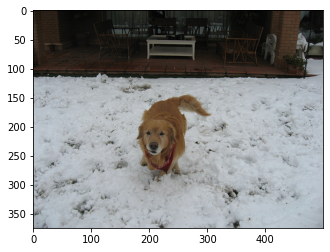

In [11]:
import matplotlib.pyplot as plt

def display_img_captions(idx):

    plt.figure()
    img = cv2.imread(train_images[idx]) # image read
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # obtaining RGB IMAGE
    plt.imshow(img)

    for cap in train_img_cap_dict[train_images[idx]]:
        print(cap) 
    
display_img_captions(80)  # 116th image & its corresponding captions   

### DEFINING THE CNN MODEL FOR TRANSFER LEARNING

In [12]:
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # pretrained model
from tensorflow.keras.layers import Flatten,Dense

model_incept = ResNet50(weights='imagenet',include_top = True) # learnt weights

x = model_incept.layers[-2].output

cnn_model = Model(inputs = model_incept.input,outputs = x)

print("\n") 
print("Image input shape ",model_incept.input) # input(IMAGE)

print("Image feature desired shape ",model_incept.layers[-2].output) # output(VECTOR)

cnn_model.summary() 
        

102981632/102967424 [==============================] - 1s 0us/step


Image input shape  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Image feature desired shape  KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
______________________________________________________________________

### OBTAIN THE FEATURE REPRESENTATION OF THE IMAGES USING CNN MODEL 

In [13]:
from tqdm import tqdm
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# function define
def preprocess(image_path): # PREPROCESS
    img = load_img(image_path, target_size=(224,224))
    x = img_to_array(img)   # convert to numpy array matrix
    x = np.expand_dims(x, axis=0) # expanding the 3rd dimension (1,224,224)
    x = preprocess_input(x)  # pixel values transform (NORMALIZATION)
    return x 

# function define
def encode(image): 
    image = preprocess(image) 
    fea_vec = cnn_model.predict(image) # returns the feature vector
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshaping to 2048 values
    return fea_vec

train_image_features = []  # to store 6k image features   

for im in tqdm(train_images[0:3500]): # image id's (just 3500 image features)
    x = encode(im)   # function call
    train_image_features.append(x)  # appending 

                                    
print(len(train_image_features))  # 6k images encoded 
print(train_image_features[0].shape)      #--> 10 minutes for execution                                   

100%|██████████| 3500/3500 [05:30<00:00, 10.57it/s]

3500
(2048,)


## **TEXT DATA EDA**

In [ ]:
# BASIC TEXT DATA ANALYSIS

import string
# obtain individual captions 
train_individual_eda = []
list_train_dict_values = list(train_img_cap_dict.values())
for lst in list_train_dict_values[0:3500]:
    for sent in lst:
        train_individual_eda.append(sent)

print("Length of individual captions -->",len(train_individual_eda))
print(train_individual_eda[0:6])

train_individual_eda_new = []
translator = str.maketrans('', '', string.punctuation) # punctuations removal object 

# TRAINING CAPTIONS 
for caps in train_individual_eda:
    desc = caps.split() 
        # convert each word to lowercase 
    desc = [word.lower() for word in desc]
        # remove punctuations
    desc = [w.translate(translator) for w in desc]
        # remove tokens with numbers in them
    desc = [word for word in desc if word.isalpha()]

    train_individual_eda_new.append(' '.join(desc).strip())

print('\n')
print("Length of individual captions(After cleaning) -->",len(train_individual_eda_new))
print(train_individual_eda_new[0:6])

Length of individual captions --> 17500
['A child in a pink dress is climbing up a set of stairs in an entry way .\n', 'A girl going into a wooden building .\n', 'A little girl climbing into a wooden playhouse .\n', 'A little girl climbing the stairs to her playhouse .\n', 'A little girl in a pink dress going into a wooden cabin .\n', 'A black dog and a spotted dog are fighting\n']


Length of individual captions(After cleaning) --> 17500
['a child in a pink dress is climbing up a set of stairs in an entry way', 'a girl going into a wooden building', 'a little girl climbing into a wooden playhouse', 'a little girl climbing the stairs to her playhouse', 'a little girl in a pink dress going into a wooden cabin', 'a black dog and a spotted dog are fighting']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


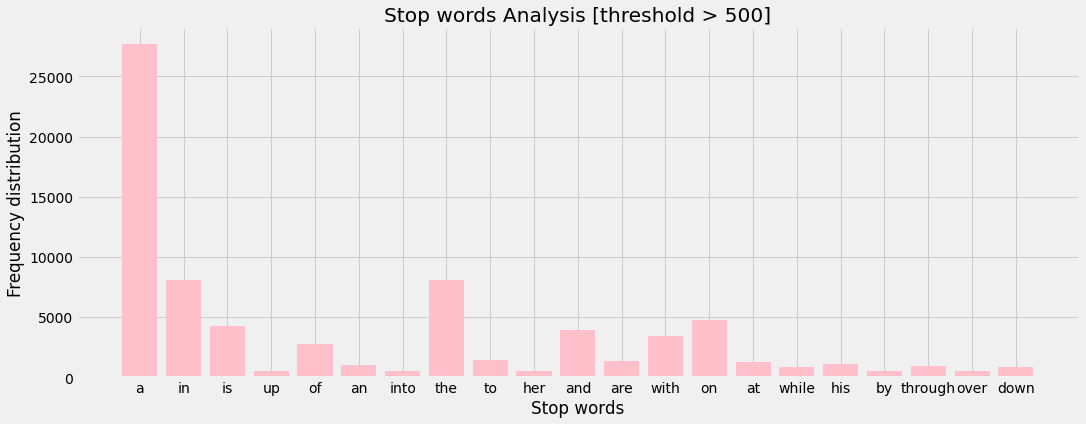

In [ ]:
# STOP WORD ANALYSIS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

word_count_threshold = 500
stop_counts = {} 
                                   
for sent in train_individual_eda_new:
    for w in sent.split():
        if w in stop:
           stop_counts[w] = stop_counts.get(w, 0) + 1

stop_words = {k:v for k,v in stop_counts.items() if v >= word_count_threshold}

keys = stop_words.keys()
values = stop_words.values()
plt.figure(figsize = (16,6))
plt.style.use('fivethirtyeight')
plt.bar(keys,values,color = 'pink')
plt.xlabel('Stop words')
plt.ylabel('Frequency distribution')
plt.title('Stop words Analysis [threshold > {}]'.format(word_count_threshold))
plt.show() 

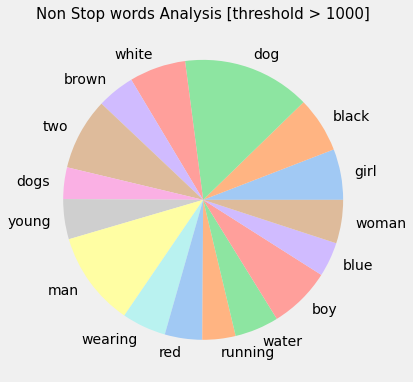

In [ ]:
import seaborn as sns
word_count_threshold = 1000
nonstop_counts = {} 
                                   
for sent in train_individual_eda_new:
    for w in sent.split():
        if w not in stop:
           nonstop_counts[w] = nonstop_counts.get(w, 0) + 1

nonstop_words = {k:v for k,v in nonstop_counts.items() if v >= word_count_threshold}

keys = nonstop_words.keys()
values = nonstop_words.values()
plt.figure(figsize = (16,6))
plt.style.use('fivethirtyeight')
colors = sns.color_palette('pastel')
plt.pie(values,labels = keys,colors = colors)
plt.title('Non Stop words Analysis [threshold > {}]'.format(word_count_threshold),fontdict = {'fontsize' : 15})
plt.show() 

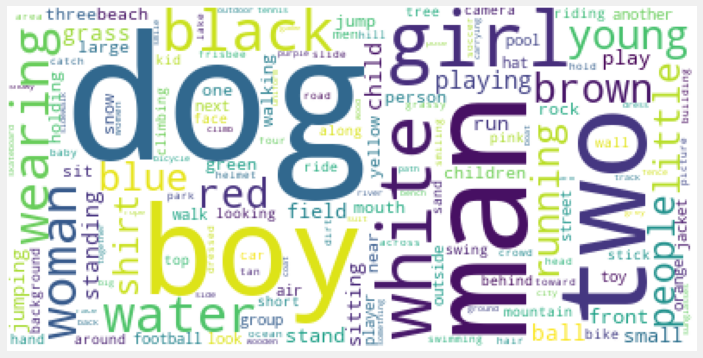

In [ ]:
from wordcloud import WordCloud


def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=150,
        max_font_size=None,
        collocations=False,
        random_state=9)
   
    wordcloud = wordcloud.generate(data)

    fig = plt.figure(1,figsize = (11,16))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

corpus = []
for sent in train_individual_eda_new:
    for w in sent.split():
        if w not in stop:
           corpus.append(w)

show_wordcloud(' '.join(corpus))

### CAPTION(TEXT DATA) CLEANING  

In [17]:
## caption cleaning --> warning -> dont run this code multiple time
import string
from tqdm import tqdm

# NOTE : train_img_cap_dict --> key -> image , values -> 5 captions

translator = str.maketrans('', '', string.punctuation) # punctuations removal object 

# TRAINING CAPTIONS 
for key,desc_list in tqdm(train_img_cap_dict.items()):
      
    for i in range(len(desc_list)):  # iterating all the 5 captions
        desc = desc_list[i]     
        desc = desc.split() 
        # convert each word to lowercase 
        desc = [word.lower() for word in desc if len(word) > 1]
        # remove punctuations
        desc = [w.translate(translator) for w in desc]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # add 'sos' & 'eos' tokens
        desc_list[i] =  'sos ' + ' '.join(desc).strip() + ' eos'  


    train_img_cap_dict[key] = desc_list   # cleaned captions are restored

# TESTING CAPTIONS
for key,desc_list in tqdm(test_img_cap_dict.items()):
    
    for i in range(len(desc_list)):  # iterating all the 5 captions
        desc = desc_list[i]    
        desc = desc.split()
        # convert each word to lowercase
        desc = [word.lower() for word in desc if len(word) > 1]
        # remove punctuations
        desc = [w.translate(translator) for w in desc]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # add 'sos' & 'eos' tokens
        desc_list[i] = ' '.join(desc).strip() + ' eos'  


    test_img_cap_dict[key] = desc_list # cleaned captions are restored

print('\n')
# After processing the train & test captions 
print(train_img_cap_dict['/content/image_captions/Images/1000268201_693b08cb0e.jpg'])

print(test_img_cap_dict['/content/image_captions/Images/3509575615_653cbf01fc.jpg'])  

100%|██████████| 2091/2091 [00:00<00:00, 17439.40it/s]



['sos child in pink dress is climbing up set of stairs in an entry way eos', 'sos girl going into wooden building eos', 'sos little girl climbing into wooden playhouse eos', 'sos little girl climbing the stairs to her playhouse eos', 'sos little girl in pink dress going into wooden cabin eos']
['crowd is standing in front of building while holding newspapers and holding flags eos', 'adults and children demonstrating in town eos', 'group of people holding red flags and pamphlets in front of large building eos', 'group of people stand together holding papers and flags eos', 'people supporting cause eos']


### GENERATING 30K TRAINING IMAGE FEATURES FOR CORRESPONDING 30K TRAINING CAPTIONS

In [18]:
def train_data_generator(train_image_features,train_img_cap_dict):

    X_in_train =  list() 
    lst_of_lsts = list(train_img_cap_dict.values()) 

    for ix,feat in enumerate(train_image_features[0:3500]):  
        
        for i in range(len(lst_of_lsts[ix])):
      
            X_in_train.append(feat) 
        
    return X_in_train


X_in_train = train_data_generator(train_image_features,train_img_cap_dict)

print(len(X_in_train)) 

17500


### OBTAINING 30K INDIVIDUAL TRAINING CAPTIONS

In [21]:
# obtain individual captions 
train_individual_captions = []
list_train_dict_values = list(train_img_cap_dict.values())
for lst in list_train_dict_values[0:3500]:
    for sent in lst:
        train_individual_captions.append(sent)

print("Length of individual captions -->",len(train_individual_captions))  

Length of individual captions --> 17500


### BUILDING VOCABULARY FROM THE ENTIRE CORPUS

In [22]:
# Consider only words which occur at least 5 times in the corpus
word_count_threshold = 5
word_counts = {} 
nsents = 0     
                               
for sent in train_individual_captions[0:3000]:
    nsents += 1
    for w in sent.split():
        word_counts[w] = word_counts.get(w, 0) + 1

vocabs = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print("Distinct word count -->",len(word_counts))  
print('preprocessed word count --> ',len(vocabs))                            
print(vocabs[0:3]) 

Distinct word count --> 2435
preprocessed word count -->  651
['sos', 'child', 'in']


### CREATING WORD-INDEX & INDEX-WORD DICTIONARIES FOR FUTURE USE

In [23]:
# word index vocabulary dictionary
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabs:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print(vocab_size) 

652


In [ ]:
# EXTRAS
#import shutil
#path = './output_folder/'
#shutil.rmtree(path,ignore_errors=True)  

### GLOVE WORD EMBEDDING (200 Dimensions) 

In [40]:
!unzip "/content/drive/MyDrive/glove.6B.200d.txt.zip" -d "/content/output_folder"         

Archive:  /content/drive/MyDrive/glove.6B.200d.txt.zip
  inflating: /content/output_folder/glove.6B.200d.txt  


In [41]:
# load word embedding vectors
embeddings_index = {}
glove_path =  '/content/output_folder/glove.6B.200d.txt' 
f = open(glove_path, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]  
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs    

# Create embedding matrix for word embedding layer
embedding_dim = 200 
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word,i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector        

print('No of word vectors :-\n',len(embeddings_index))
emb_dim = coefs.shape[0]  
print("Dimension of word vector :-\n",embedding_dim)
print("Shape of embedding matrix :-\n",embedding_matrix.shape)       

No of word vectors :-
 400000
Dimension of word vector :-
 200
Shape of embedding matrix :-
 (652, 200)


### ANALYSIS ON LENGTH OF WORDS IN EACH CAPTION 

Length of word indices :- 2435
Word index for the word 'black' --> 18


The mean length of words in the sequences :-
 11.432333333333334


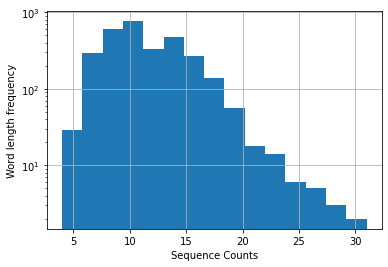

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# Tokenize our training data 
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_individual_captions[0:3000]) 

# Get our training data word-index  dictionary
word_index = tokenizer.word_index    #--> its a vocab dictionary
print("Length of word indices :-",len(word_index))
print("Word index for the word 'black' -->",word_index['black'])
print('\n')  

# Encode training data sentences into sequences of integers 
train_sequences = tokenizer.texts_to_sequences(train_individual_captions[0:3000])

# Get max training sequence length  
import statistics ; import matplotlib.pyplot as plt;
lengths = [len(x) for x in train_sequences]
print("The mean length of words in the sequences :-\n",statistics.mean(lengths))
plt.hist(lengths,bins = 15)
plt.xlabel('Sequence Counts')
plt.ylabel('Word length frequency')
plt.grid()
plt.yscale('log') 
plt.show() 

### DEFINE BATCH DATA GENERATOR FOR FINAL MODEL TRAINING

In [34]:
def batch_generator(train_img_cap_dict,train_image_features,wordtoix,max_length):#num_photos_per_batch):
    
    X1, X2, y = list(), list(), list() 
  
    
    for idx,key_caps in enumerate(list(train_img_cap_dict.items())[0:3000]):

            # retrieve the photo bottle neck feature
        bottle_neck_feat = train_image_features[idx]  # feature 2048 values 
            
        for desc in key_caps[1]: 
            # encode the sequence 
            seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
              
            #['sos','love','life','hectic']
            #[3,16,14,123]
                # split one sequence into multiple X, y pairs

            for i in range(1,len(seq)):
                    
                    # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length,padding = 'post',truncating = 'post')[0]

                    # encode output sequence 
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store 
                X1.append(bottle_neck_feat)
                X2.append(in_seq)
                y.append(out_seq) 
            
    return X1,X2,y 
                       

In [35]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
max_length = 20  # 
X1,X2,y = batch_generator(train_img_cap_dict,train_image_features,wordtoix,max_length) 

In [36]:
print(type(X1[0]))
print(X2[0].shape) 

<class 'numpy.ndarray'>
(20,)


In [37]:
import numpy as np
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)
print("Shapes of data  \n")
print(X1.shape)
print(X2.shape)
print(y.shape) 

Shapes of data  

(136928, 2048)
(136928, 20)
(136928, 652)


In [24]:
# NECESSARY DEEP LEARNING PACKAGES
from keras import Input,layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,Activation,Flatten,Reshape,Dropout,TimeDistributed,RepeatVector,Concatenate
from tensorflow.keras.layers import SimpleRNN,LSTM
from keras.layers.merge import add
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler 
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.models import load_model

### DEFINE THE FINAL CNN-RNN MODEL 

In [38]:
max_length = 20
emb_dim = 200 

# image features
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(200, activation='relu')(fe1)
fe3 = Dense(128, activation='relu')(fe2)
fe4 = RepeatVector(max_length)(fe3)  #########

# text features
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,emb_dim,input_length = max_length,mask_zero = True)(inputs2)
se2 = Dropout(0.3)(se1) 
se3 = LSTM(256,return_sequences=True)(se2)  # using LSTMs
se4 = TimeDistributed(Dense(emb_dim))(se3)

# hidden states output concatenation
decoder1 = Concatenate()([fe4,se4])
decoder2 = LSTM(128,return_sequences =  True)(decoder1)
decoder3 = LSTM(512,return_sequences =  False)(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1,inputs2],outputs=outputs)

model.summary()  

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 200)      130400      input_3[0][0]                    
____________________________________________________________________________________________

### MAKE TRAINABLE = FALSE FOR EMBEDDING LAYER

In [42]:
model.layers[3].set_weights([embedding_matrix])
model.layers[3].trainable = False 

### COMPILING THE FINAL MODEL

In [43]:
from tensorflow.keras.optimizers import Adam 
model.compile(loss='categorical_crossentropy', optimizer= 'Adam',metrics=['accuracy']) 

In [ ]:
# Clear any logs of previous executions/runs
#import shutil
#path = './model_save_1/'
#shutil.rmtree(path,ignore_errors=True)  

### FINAL MODEL BATCH TRAINING 

In [44]:
model.fit([X1,X2],y, batch_size = 512,epochs=50)  # 40-45 minutes execution  -->  
# 3500 IS THE LIMIT, bcz RAM consumption is high & almost 11.5 GB while training in batches.

Epoch 1/50
268/268 [==============================] - 33s 73ms/step - loss: 4.5374 - accuracy: 0.1617
Epoch 2/50
268/268 [==============================] - 20s 73ms/step - loss: 3.7917 - accuracy: 0.2352
Epoch 3/50
268/268 [==============================] - 19s 73ms/step - loss: 3.3961 - accuracy: 0.2761
Epoch 4/50
268/268 [==============================] - 19s 73ms/step - loss: 3.1575 - accuracy: 0.3039
Epoch 5/50
268/268 [==============================] - 20s 73ms/step - loss: 2.9892 - accuracy: 0.3262
Epoch 6/50
268/268 [==============================] - 20s 73ms/step - loss: 2.8561 - accuracy: 0.3432
Epoch 7/50
268/268 [==============================] - 20s 73ms/step - loss: 2.7424 - accuracy: 0.3591
Epoch 8/50
268/268 [==============================] - 20s 73ms/step - loss: 2.6393 - accuracy: 0.3739
Epoch 9/50
268/268 [==============================] - 19s 73ms/step - loss: 2.5418 - accuracy: 0.3892
Epoch 10/50
268/268 [==============================] - 19s 72ms/step - loss: 2.450

In [52]:
model.save('/content/drive/MyDrive/my_model_8268.h5')        

### VALIDATE THE PERFORMANCE OF THE MODEL (Greedy search approach)

In [47]:
max_length = 20
def greedySearch(photo):                                                               
    in_text = 'sos'      
    
    for i in range(max_length):   

        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix] 
        
        sequence = pad_sequences([sequence], maxlen = max_length,padding = 'post',truncating = 'post')#[0]   
        
        yhat = model.predict([photo,sequence],verbose=0)    
        #print(yhat)
        yhat_val = np.argmax(yhat) 
        #print(yhat_val)
        word = ixtoword[yhat_val]   
        #print(word) 
        in_text += ' ' + word
            
        if word == 'eos': 
            break
        
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    #print()   
    #print(yhat.shape)    
    return final  


Enter the image id :- 56
Original image & its captions
sos group of eight people are gathered around table at night eos
sos group of people gathered around in the dark eos
sos group of people sit around table outside on porch at night eos
sos group of people sit outdoors together at night eos
sos group of people sitting at table in darkened room eos

Predicted caption
Enter the image id :- 675
Original image & its captions
sos boy in red jacket smacks snow covered tree with stick eos
sos child stands underneath snowcovered tree eos
sos little boy shakes the snow off of tree eos
sos person in red jacket stands under snowcovered tree eos
sos child standing in snowy landscape pulling down snowcovered tree branch eos

Predicted caption
Enter the image id :- 2789
Original image & its captions
sos a boy held by man points his arm towards the sky as another boy peers through his hands into the air eos
sos boy in blue and white shirt is pointing up and second boy in white shirt shields his eye

<Figure size 432x288 with 0 Axes>

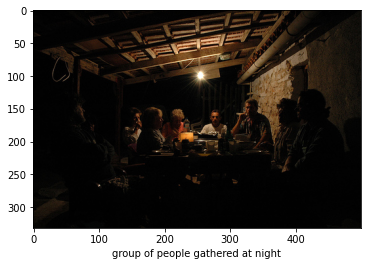

<Figure size 432x288 with 0 Axes>

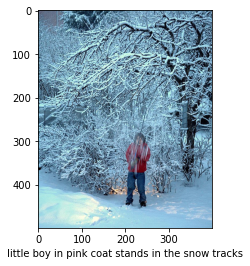

<Figure size 432x288 with 0 Axes>

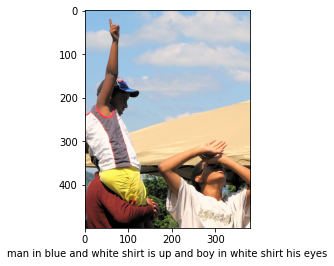

In [51]:
for i in range(3):
    check =  int(input("Enter the image id :- ")) # totally 3000 unique images trained
    print("Original image & its captions") 
    plt.figure()
    display_img_captions(check)              
    print("\nPredicted caption") 
    pic = train_image_features[check].reshape((1,2048))
    caption = greedySearch(pic)
    plt.xlabel(caption)  # 103,800,1035      --> # 10,80,105 

In [53]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/drive/MyDrive/my_model_8268.h5') 

## GRADIO WEB APPLICATION (DEPLOYMENT)

In [54]:
!pip install gradio 

     |████████████████████████████████| 2.0 MB 5.5 MB/s 
     |████████████████████████████████| 1.9 MB 34.8 MB/s 
     |████████████████████████████████| 206 kB 52.2 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 961 kB 37.3 MB/s 
     |████████████████████████████████| 3.5 MB 36.4 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=342919071e3400b857d3bf3ade1af5b5cc48914c986c5ced88230cde30d54a46
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=202a5553e8ebaeb090f47c3f745e3fd0a74712407fe607c2caf5554ddc1aa4ce
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [55]:
import cv2
def describe_img(im_g):
    x = im_g.reshape(-1,224,224,3)
    x = preprocess_input(x)  # pixel values transform (NORMALIZATION)
    fea_vec = cnn_model.predict(x) # returns the feature vector
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshaping to 2048 values
    pic = fea_vec.reshape((1,2048))
    caption = greedySearch(pic)
    return caption 

In [ ]:
import gradio as gr
input_img = gr.inputs.Image(shape=(224,224),label = 'IMAGE CAPTIONER SYSTEM')
iface = gr.Interface(describe_img,inputs = input_img,outputs = 'text',capture_session = True)
iface.launch(debug = True) 

### BLEU SCORE MEASURE FOR SAMPLE TRAIN & TEST IMAGES 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


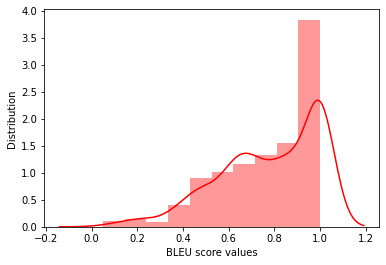

In [58]:
# performance metric --> BLEU score # exec time --> 5 min
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

smoothie = SmoothingFunction().method2 
#reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
#candidate = ['test', 'a', 'is', 'this']
#score = sentence_bleu(reference, candidate,smoothing_function=smoothie,weights = (0.75,0.25,0,0))
#print(score) 

list_train_dict_values = list(train_img_cap_dict.values())[500:1000]
bleu_scores = []
for idx,lst in enumerate(list_train_dict_values): # 500-1000 images
       
    ref = [lst_val.split() for lst_val in lst]
    
    pic = train_image_features[idx+500].reshape((1,2048))
    pred_cap = greedySearch(pic).split()
    bleu_scores.append(sentence_bleu(ref,pred_cap,smoothing_function=smoothie,weights = (1,0,0,0)))

import seaborn as sns     
sns.distplot(bleu_scores,color="r")
plt.xlabel('BLEU score values')
plt.ylabel('Distribution') 
plt.show() # Scores over 0.30 generally reflect understandable translations 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


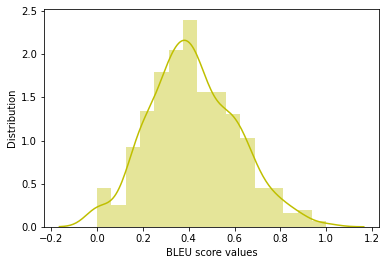

In [59]:
# performance metric --> BLEU score # exec time --> 5 min
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

smoothie = SmoothingFunction().method2 
#reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
#candidate = ['test', 'a', 'is', 'this']
#score = sentence_bleu(reference, candidate,smoothing_function=smoothie,weights = (0.75,0.25,0,0))
#print(score) 

list_train_dict_values = list(train_img_cap_dict.values())[3000:3500]
bleu_scores = []
for idx,lst in enumerate(list_train_dict_values): # 3000-3500 images
       
    ref = [lst_val.split() for lst_val in lst]
    
    pic = train_image_features[idx+3000].reshape((1,2048))
    pred_cap = greedySearch(pic).split()
    bleu_scores.append(sentence_bleu(ref,pred_cap,smoothing_function=smoothie,weights = (1,0,0,0)))

import seaborn as sns     
sns.distplot(bleu_scores,color="y")
plt.xlabel('BLEU score values')
plt.ylabel('Distribution')
plt.show()    # Scores over 0.30 generally reflect understandable translations 